In [1]:
#import data by kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

 99% 156M/158M [00:08<00:00, 23.9MB/s]
100% 158M/158M [00:08<00:00, 19.2MB/s]


In [3]:
#file unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/covid19-image-dataset.zip') 
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
import os
import PIL 
import pathlib
import tensorflow as tf
from tensorflow import keras

In [5]:
train_dir = pathlib.Path('/content/Covid19-dataset/train')
val_dir = pathlib.Path('/content/Covid19-dataset/test')
train_image_count = len(list(train_dir.glob('*/*.jpg'))) 
train_image_count

57

In [6]:
batch_size = 32 
image_width = 224 
image_height = 224

train_ds = keras.preprocessing.image_dataset_from_directory( train_dir,
  seed=123,
  #validation_split=0.5, #subset='training', 
  image_size=(image_height, image_width), 
  batch_size=batch_size
)
val_ds = keras.preprocessing.image_dataset_from_directory( val_dir,
  seed=123,
  image_size=(image_height, image_width), 
  batch_size=batch_size
)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


In [7]:
#check data class
class_names = train_ds.class_names
class_names

['Covid', 'Normal', 'Viral Pneumonia']

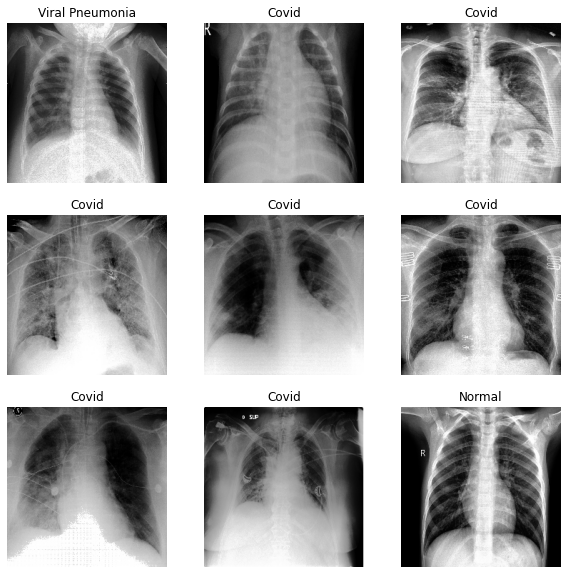

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1) 
    plt.imshow(images[i].numpy().astype('uint8')) 
    plt.title(class_names[labels[i]]) 
    plt.axis('off')

In [9]:
# Criando o modelo base em cima do modelo MobileNetV3
base_model = keras.applications.MobileNetV3Small(input_shape=(image_width, image_height, 3),
                                            classes=400,
                                            include_top=False,
                                            weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [10]:
# Freeze convolutional base
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [11]:
data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [12]:
num_classes = len(class_names)# 7

inputs = keras.Input(shape=(image_width, image_height, 3))
#x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [13]:
#compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 3)                 1731      
                                                                 
Total params: 940,851
Trainable params: 1,731
Non-trainable p

In [14]:
#fitting model
initial_epochs = 10

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(train_ds, 
          validation_data=val_ds,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/10
8/8 [==============================] - 15s 289ms/step - loss: 1.1180 - accuracy: 0.4582 - val_loss: 0.8424 - val_accuracy: 0.6364
Epoch 2/10
8/8 [==============================] - 4s 98ms/step - loss: 0.8385 - accuracy: 0.6016 - val_loss: 0.6612 - val_accuracy: 0.6970
Epoch 3/10
8/8 [==============================] - 4s 100ms/step - loss: 0.6304 - accuracy: 0.7610 - val_loss: 0.5969 - val_accuracy: 0.7273
Epoch 4/10
8/8 [==============================] - 4s 102ms/step - loss: 0.5084 - accuracy: 0.8167 - val_loss: 0.5229 - val_accuracy: 0.7576
Epoch 5/10
8/8 [==============================] - 5s 98ms/step - loss: 0.4243 - accuracy: 0.8406 - val_loss: 0.4612 - val_accuracy: 0.7727
Epoch 6/10
8/8 [==============================] - 4s 101ms/step - loss: 0.4193 - accuracy: 0.8367 - val_loss: 0.4408 - val_accuracy: 0.7879
Epoch 7/10
8/8 [==============================] - 4s 100ms/step - loss: 0.3538 - accuracy: 0.8845 - val_loss: 0.4179 - val_accuracy: 0.8030
Epoch 8/10
8/8 [=====

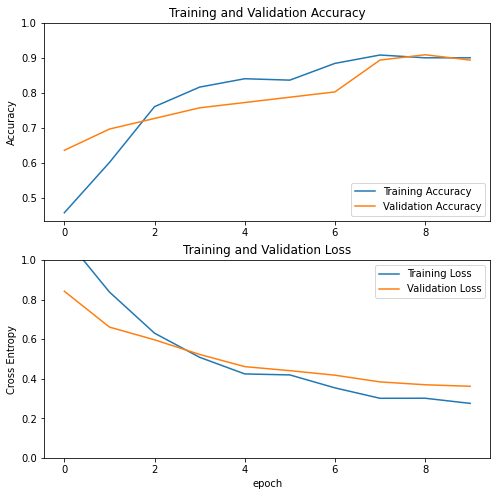

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 897ms/step


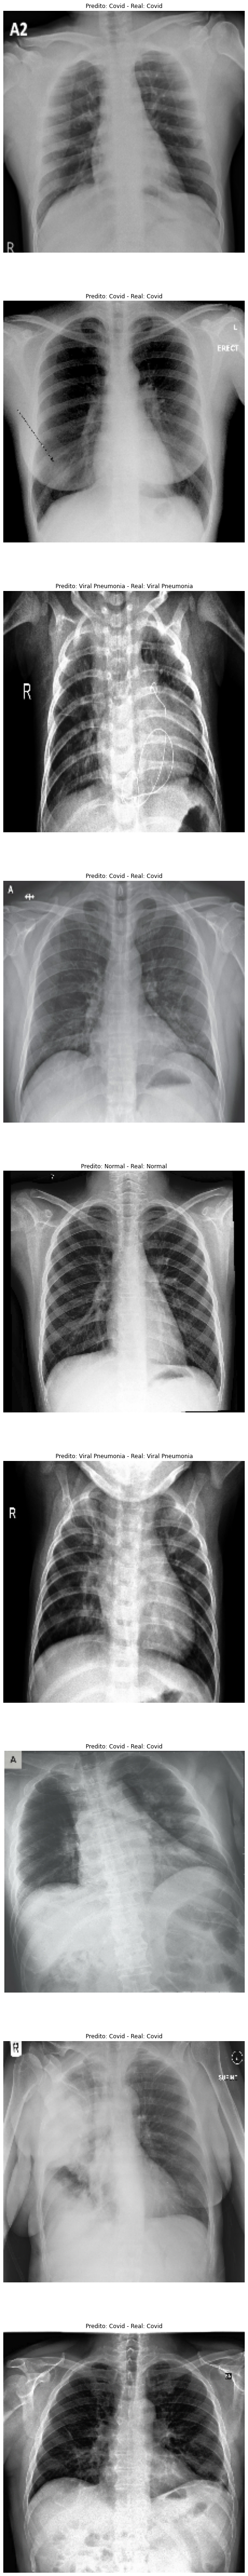

In [20]:
plt.figure(figsize=(10, 100))
for images, labels in val_ds.take(1):
    prediction = model.predict(images,batch_size=32)
    for i in range(9):
        ax = plt.subplot(9, 1, i+1)
        pred = np.argmax(prediction[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Predito: {class_names[pred]} - Real: {class_names[labels[i]]}')
        plt.axis('off')

In [18]:
#Visualize the result
results = model.evaluate(val_ds, verbose=0)

In [19]:
print(" Test Loss: {:.5f}".format(results[0]))
print(" Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 Test Loss: 0.36185
 Accuracy on the test set: 89.39%


In [22]:
y_test = np.concatenate([y for x, y in val_ds], axis=0)
prediction = model.predict(val_ds)
pred = np.argmax(prediction,axis=1)
print(pred)    
from sklearn.metrics import accuracy_score

accuracy_score(pred,y_test)

3/3 [==============================] - 1s 23ms/step
[2 1 1 0 2 2 0 1 0 0 1 1 1 2 0 2 2 1 1 0 2 2 0 2 2 0 0 0 0 1 0 1 0 0 2 2 0
 2 2 2 2 2 0 2 1 2 2 2 1 0 2 0 1 0 2 2 0 2 0 0 0 1 0 0 0 1]


0.42424242424242425

In [24]:
#save model
model.save('/content/drive/MyDrive/Colab Notebooks/Covid-19.h5')